# Sensitivity of LRTest

We use the negative binomial (NB) distribution as an example. We introduce a condition by adding delta to the NB mean and perform a LRT between control and with the condition added.

In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [4]:
from tensorzinb.lrtest import LRTest
import numpy as np
import pandas as pd
import time
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import uniform, binom, nbinom, bernoulli
import statsmodels.api as sm

In [5]:
plt.style.use('ggplot')

In [6]:
def gen_nb_test_df(delta=1):
    np.random.seed(0)                 # set seed to replicate example
    nobs= 25000                          # number of obs in model 

    x1 = binom.rvs(1, 0.5, size=nobs)   # categorical explanatory variable
    x2 = uniform.rvs(size=nobs)         # real explanatory variable

    theta = 0.5
    X = sm.add_constant(np.column_stack((x1, x2)))
    beta = [1.0, 1.0, -1.0]
    xb = np.dot(X, beta)          # linear predictor

    condition = np.zeros(nobs)
    condition[:int(nobs/2)]=1

    exb = np.exp(xb+condition*delta)
    nby = nbinom.rvs(exb, theta)

    df_data=pd.DataFrame(nby,columns=['test'])
    df_feature=pd.DataFrame(X,columns=['f_{}'.format(i) for i in range(len(beta))])
    df_feature['condition']=condition
    
    return df_data, df_feature

def get_statsmodels_lrt(lrtest):
    mod0 = sm.NegativeBinomial(lrtest.df_data.values[:,0], lrtest.Xs[0]).fit(maxiter=200, disp=False, warn_convergence=False)
    mod1 = sm.NegativeBinomial(lrtest.df_data.values[:,0], lrtest.Xs[1]).fit(maxiter=200, disp=False, warn_convergence=False)
    lld=mod1.llf-mod0.llf
    dfd = lrtest.res1["df"] - lrtest.res0["df"]
    pvalue = 1 - stats.chi2.cdf(2 * lld, dfd)
    return lld,pvalue,dfd
    

In [7]:
ds=0.01+0.005*np.arange(9)

In [8]:
res=[]
for d in ds:
    df_data, df_feature = gen_nb_test_df(d)
    nb_features = list(df_feature.columns)[:-1]
    conditions = ['condition']
    
    lrtest = LRTest(df_data,df_feature,conditions, nb_features, add_intercept=False)
    dfr=lrtest.run()
    row=dfr.iloc[0]
    r = [d, row.llfd, row.pvalue]
    r_stats = get_statsmodels_lrt(lrtest)
    r=r+list(r_stats)
    res.append(r)
    
res=np.array(res)

Metal device set to: Apple M4 Pro

systemMemory: 24.00 GB
maxCacheSize: 8.00 GB



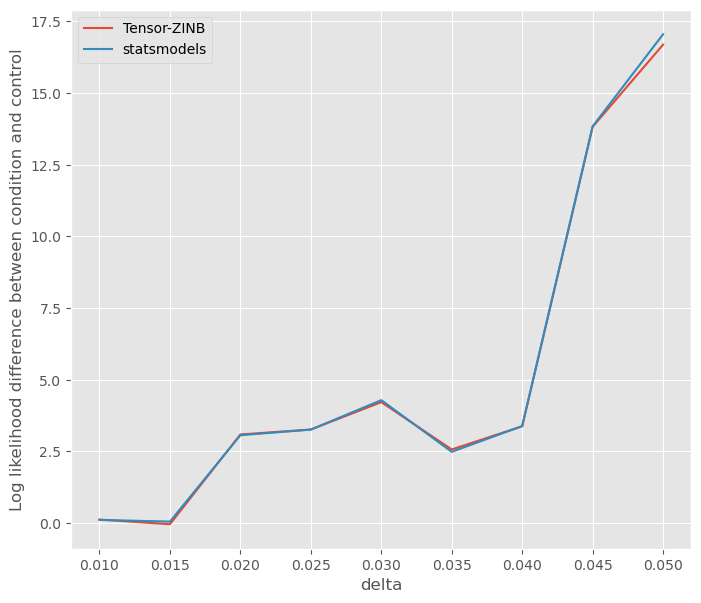

In [9]:
plt.figure(figsize=(8,7))
plt.plot(res[:,0],res[:,1],label='Tensor-ZINB')
plt.plot(res[:,0],res[:,3],label='statsmodels')
plt.xlabel('delta')
plt.ylabel('Log likelihood difference between condition and control')
plt.legend()

we can see that log likelihood difference roughly increases as delta increase, which agrees with the intuition that the "control" and "condition" will be more different as delta increases.

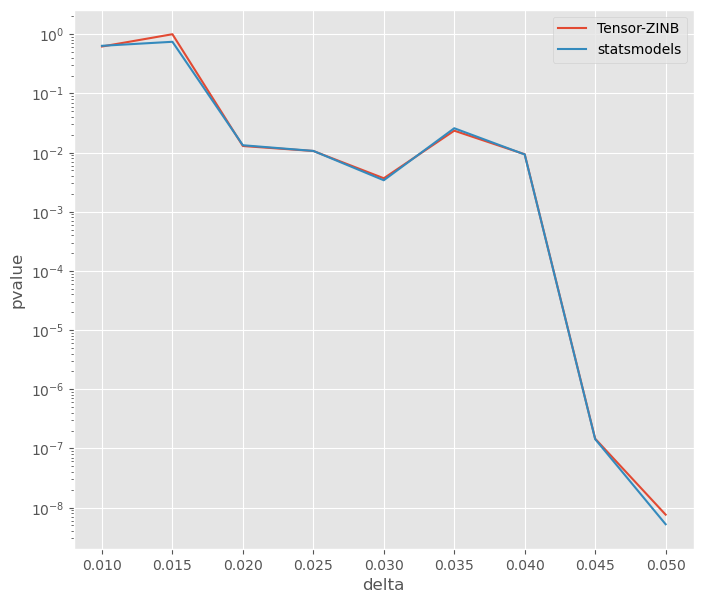

In [10]:
plt.figure(figsize=(8,7))
plt.semilogy(res[:,0],res[:,2],label='Tensor-ZINB')
plt.semilogy(res[:,0],res[:,4],label='statsmodels')
plt.xlabel('delta')
plt.ylabel('pvalue')
plt.legend()

we find there is a sharp drop of pvalue when delta is greater than 0.015~0.025. This shows that LRT is sensitive to the change of mean in distribution.

TensorZINB and statsmodels return almost identical results on this simulation data

In [11]:
dfp=df_data.copy()
dfp['condition']=df_feature['condition']

this shows the difference of mean between the "control" and "condition".

In [12]:
dfp.groupby('condition').mean()

,test
condition,
0.0,3.18320
1.0,3.36968


<Axes: xlabel='test', ylabel='Percent'>

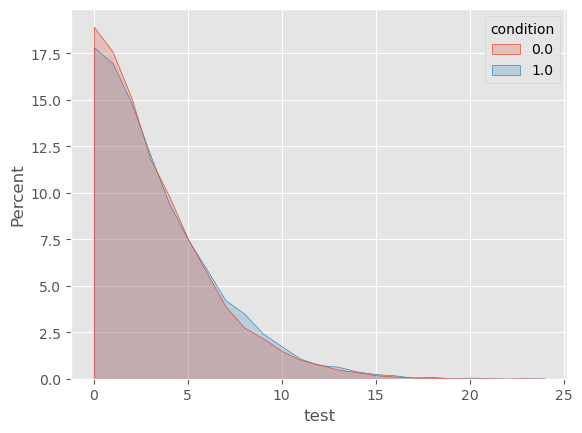

In [13]:
sns.histplot(dfp,x='test',hue='condition',stat="percent",element="poly",discrete=True,common_norm=False)